In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [31]:
!cd '/kaggle/input/ph2dataset/PH2Dataset'

In [31]:
images = []
lesions = []
from skimage.io import imread
import os
root = '/kaggle/input/ph2dataset/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [32]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [33]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [35]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [36]:
print(len(tr), len(val), len(ts))

100 50 50


In [37]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [38]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
!pip install torchmetrics

In [3]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

In [16]:
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [6]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [8]:
def bce_loss(y_pred, y_real):
  y_pred_sigmoid = torch.sigmoid(y_pred)
  loss = - (y_real * torch.log(y_pred_sigmoid + 1e-10) + (1 - y_real) * torch.log(1 - y_pred_sigmoid + 1e-10))
  return loss.sum()

def bce_true(y_pred, y_real):
  loss=y_real*torch.log(torch.sigmoid(y_pred))+(1-y_real)*torch.log(1-torch.sigmoid(y_pred))
  return -loss.sum()

In [9]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')

BCE loss from scratch bce_loss = 5.559488773345947
BCE loss честно посчитанный = 5.559488773345947
BCE loss from torch bce_torch = 5.559488773345947
BCE loss from torch with logits bce_torch = 5.559488296508789


In [12]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

In [13]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 12.90007495880127
BCE loss честно посчитанный = 12.90007495880127
BCE loss from torch bce_torch = 12.90007495880127
BCE loss from torch with logits bce_torch = 12.90007495880127


In [14]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

In [15]:
path_to_dummy_samples = '/kaggle/input/for-asserts/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt',weights_only=True),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt',weights_only=True)}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

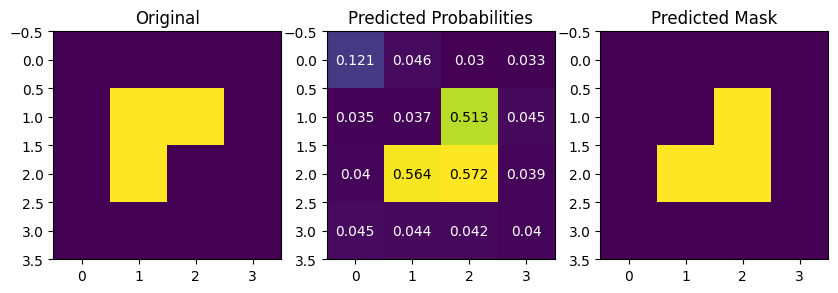

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

In [19]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [21]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # VGG-16 architecture
        self.enc_conv0 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=64),
        )
        self.MaxPool_0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=128),
        )
        self.MaxPool_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 128-> 64

        self.enc_conv2 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=256),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=256),
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=512),
        )
        self.MaxPool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 64-> 32
        # bottleneck1
        self.bottle = nn.Conv2d(512, 512, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv0 = nn.Sequential(
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=512),
        nn.ConvTranspose2d(512, 256, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=256),
        nn.ConvTranspose2d(256, 256, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=256),
        nn.ConvTranspose2d(256, 128, 3, padding=1),
        )



        self.upsample1 = nn.Upsample(scale_factor=2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=128),
        nn.ConvTranspose2d(128, 128, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=128),
        nn.ConvTranspose2d(128, 64, 3, padding=1),
        )

        self.upsample2 = nn.Upsample(scale_factor=2) # 128 -> 256
        self.dec_conv2 = nn.Sequential(
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=64),
        nn.ConvTranspose2d(64, 64, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=64),
        nn.ConvTranspose2d(64, 1, 3, padding=1),
        )

    def forward(self, x):
        # encoder
        x = self.enc_conv0(x)
        x = self.MaxPool_0(x)
        x = self.enc_conv1(x)
        x = self.MaxPool_1(x)
        x = self.enc_conv2(x)
        x = self.MaxPool_2(x)

        # bottleneck
        x = self.bottle(x)

        # decoder
        x=self.upsample0(x)
        x=self.dec_conv0(x)
        x=self.upsample1(x)
        x=self.dec_conv1(x)
        x=self.upsample2(x)
        x=self.dec_conv2(x)

        return x

In [22]:
segnet_model = SegNet().to(device)

In [24]:
from tqdm.notebook import tqdm

In [78]:
def bce_loss(y_pred, y_real):
    y_pred = torch.clip(y_pred, 1e-7, 1 - 1e-7)
    
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

In [72]:
def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')
    best_val_iou = 0
    segnet_model.train()

    for epoch in tqdm(range(epochs)):
      avg_loss_train = 0
      model.train()
      for X_batch, Y_batch in tqdm(train_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model.forward(X_batch)
          loss = criterion(Y_pred, Y_batch) # forward-pass

          loss.backward()  # backward-pass
          optimizer.step()  # update weights
          optimizer.zero_grad() # set parameter gradients to zero

          # calculate loss to show the user
          avg_loss_train += loss

      avg_loss_train = avg_loss_train/len(train_dataloader)
      total_train_loss.append(avg_loss_train)

      model.eval()
      avg_loss_val=0
      avg_iou=0
      with torch.no_grad():
        for X_batch, Y_batch in tqdm(valid_dataloader):
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            Y_pred = model(X_batch)
            iou = iou_score(Y_pred, Y_batch)
            loss = criterion(Y_pred, Y_batch)
            avg_loss_val += loss
            avg_iou += iou
            

      avg_loss_val = avg_loss_val/len(valid_dataloader)
      avg_iou = avg_iou/len(valid_dataloader)
      total_val_loss.append(avg_loss_val)
      total_val_iou.append(avg_iou)
      print(f'Epoch {epoch}: train loss = {avg_loss_train}')
      print(f'Epoch {epoch}: val loss = {avg_loss_val}')
      print(f'Epoch {epoch}: val iou = {avg_iou}')

      statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}

    return model, statistics


In [27]:
model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 25

In [39]:
torch.cuda.empty_cache()
model, statistics = train(model, optimizer, bce_loss, epochs, train_dataloader, valid_dataloader, device)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 1.156493902206421
Epoch 0: val loss = 0.7333287000656128
Epoch 0: val iou = 0.30112916231155396


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.3665558695793152
Epoch 1: val loss = 0.6786795854568481
Epoch 1: val iou = 0.0012463561724871397


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.2881743013858795
Epoch 2: val loss = 0.6374468803405762
Epoch 2: val iou = 0.00098935526330024


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.2307138592004776
Epoch 3: val loss = 0.6109931468963623
Epoch 3: val iou = 0.0009954912820830941


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.21763762831687927
Epoch 4: val loss = 0.5974572896957397
Epoch 4: val iou = 0.000991535373032093


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.198800727725029
Epoch 5: val loss = 0.6368436217308044
Epoch 5: val iou = 0.5676045417785645


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.19279758632183075
Epoch 6: val loss = 0.5364158749580383
Epoch 6: val iou = 0.007926980964839458


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.1746998429298401
Epoch 7: val loss = 0.43126559257507324
Epoch 7: val iou = 0.36518460512161255


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.17365020513534546
Epoch 8: val loss = 0.4242246747016907
Epoch 8: val iou = 0.35096508264541626


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.17905034124851227
Epoch 9: val loss = 0.47592753171920776
Epoch 9: val iou = 0.25764456391334534


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.15626424551010132
Epoch 10: val loss = 0.3930773138999939
Epoch 10: val iou = 0.5375072956085205


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.1615883708000183
Epoch 11: val loss = 0.37310078740119934
Epoch 11: val iou = 0.5211817026138306


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.14217722415924072
Epoch 12: val loss = 0.37560224533081055
Epoch 12: val iou = 0.5187756419181824


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.16186656057834625
Epoch 13: val loss = 0.28676581382751465
Epoch 13: val iou = 0.6477270126342773


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.15105119347572327
Epoch 14: val loss = 0.2582835555076599
Epoch 14: val iou = 0.6848653554916382


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.1356649398803711
Epoch 15: val loss = 0.24190539121627808
Epoch 15: val iou = 0.6962320804595947


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.123554527759552
Epoch 16: val loss = 0.23036441206932068
Epoch 16: val iou = 0.7556095123291016


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.1151571199297905
Epoch 17: val loss = 0.229954332113266
Epoch 17: val iou = 0.7581630349159241


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.1151299849152565
Epoch 18: val loss = 0.18994009494781494
Epoch 18: val iou = 0.793934166431427


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.1038469523191452
Epoch 19: val loss = 0.20196658372879028
Epoch 19: val iou = 0.7939960956573486


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: train loss = 0.1011749655008316
Epoch 20: val loss = 0.21734380722045898
Epoch 20: val iou = 0.7863190174102783


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21: train loss = 0.12601634860038757
Epoch 21: val loss = 0.1902569681406021
Epoch 21: val iou = 0.8022390604019165


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22: train loss = 0.12794746458530426
Epoch 22: val loss = 0.21868617832660675
Epoch 22: val iou = 0.7651829123497009


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23: train loss = 0.10218267142772675
Epoch 23: val loss = 0.1686217337846756
Epoch 23: val iou = 0.7969970107078552


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24: train loss = 0.10537692159414291
Epoch 24: val loss = 0.19911831617355347
Epoch 24: val iou = 0.7728877067565918


In [40]:
def test(model, metric, epochs, data):

    with torch.no_grad():
        model.eval()
        scores = 0

        for X_batch, Y_label in data:
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
            Y_pred = model(X_batch)
            Y_pred = torch.sigmoid(Y_pred)
            Y_pred[Y_pred > 0.5] = 1
            scores += (metric(Y_pred, Y_label).mean().item())

    return scores / len(data)

In [41]:
print(test(model,bce_loss,25,valid_dataloader))

0.6199453473091125


In [42]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):

    # TODO
    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > threshold).float()
    tp= torch.sum(pred_mask*labels)
    fp = torch.sum(pred_mask) - tp
    fn = torch.sum(labels) - tp
    eps = 1e-7 # to avoid 0/0
    score = (2*tp + eps) / (2*tp + fp + fn + eps)
    return score

In [43]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [44]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

In [45]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):


    # TODO
    prob_mask = logits.sigmoid()
    tp= torch.sum(prob_mask*labels)
    fp = torch.sum(prob_mask) - tp
    fn = torch.sum(labels) - tp
    eps = 1e-7 # to avoid 0/0
    score = (2*tp + eps) / (2*tp + fp + fn + eps)

    return 1-score

In [46]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=342d4da9288c7d23b1e406c43c7020329a0124fa73cd8f60f469d4e61b4642b3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=f088dcbc8ef0a08bfbb6cf0f9892f59220d69a0d0abf2878f722a18e4f79c559
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [47]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [48]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

In [49]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):

    p_t = torch.sigmoid(y_pred) * y_real + (1 - torch.sigmoid(y_pred)) * (1 - y_real)
    bce_loss_with_logits = y_real * torch.log( torch.sigmoid(y_pred) ) + (1 - y_real) * torch.log( 1 - torch.sigmoid(y_pred) )
    loss = - torch.sum( ((1 - p_t) ** gamma) * bce_loss_with_logits )

    return loss

In [50]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    y_pred = torch.clip(y_pred, eps, 1 - eps)
    bce = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    pt = torch.exp(-bce)
    focal = (1 - pt) ** gamma * bce

    return torch.mean(focal)

In [53]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [54]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

AssertionError: 

Обучение SegNet на новых лоссах

In [55]:
model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 25

In [56]:
torch.cuda.empty_cache()
model, statistics = train(model, optimizer, dice_loss, epochs, train_dataloader, valid_dataloader, device)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.3868030905723572
Epoch 0: val loss = 0.6119216680526733
Epoch 0: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.20525434613227844
Epoch 1: val loss = 0.6806864142417908
Epoch 1: val iou = 0.0025953478179872036


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.1613871455192566
Epoch 2: val loss = 0.8848216533660889
Epoch 2: val iou = 1.741732376103755e-06


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.144082710146904
Epoch 3: val loss = 0.9690209627151489
Epoch 3: val iou = 9.72471298155142e-07


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.14403198659420013
Epoch 4: val loss = 0.9906424283981323
Epoch 4: val iou = 9.520327921563876e-07


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.12879778444766998
Epoch 5: val loss = 0.9977734088897705
Epoch 5: val iou = 9.631628472561715e-07


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.11079294979572296
Epoch 6: val loss = 0.9994626045227051
Epoch 6: val iou = 9.994662377721397e-07


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.11693868041038513
Epoch 7: val loss = 0.5926723480224609
Epoch 7: val iou = 0.2596530020236969


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.10652889311313629
Epoch 8: val loss = 0.4154115319252014
Epoch 8: val iou = 0.4149687886238098


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.10597631335258484
Epoch 9: val loss = 0.47517648339271545
Epoch 9: val iou = 0.36131614446640015


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.10276186466217041
Epoch 10: val loss = 0.28024905920028687
Epoch 10: val iou = 0.5647637844085693


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.091280996799469
Epoch 11: val loss = 0.23566430807113647
Epoch 11: val iou = 0.6210030317306519


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.0861094743013382
Epoch 12: val loss = 0.18368732929229736
Epoch 12: val iou = 0.6921685934066772


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.08068843185901642
Epoch 13: val loss = 0.18459829688072205
Epoch 13: val iou = 0.688994288444519


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.07404656708240509
Epoch 14: val loss = 0.1359173059463501
Epoch 14: val iou = 0.7622666358947754


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.07922686636447906
Epoch 15: val loss = 0.1347118616104126
Epoch 15: val iou = 0.7636830806732178


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.07889986038208008
Epoch 16: val loss = 0.1333911418914795
Epoch 16: val iou = 0.7671313285827637


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.07987712323665619
Epoch 17: val loss = 0.09949034452438354
Epoch 17: val iou = 0.8205387592315674


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.09694214165210724
Epoch 18: val loss = 0.1292031705379486
Epoch 18: val iou = 0.7723550796508789


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.07036416232585907
Epoch 19: val loss = 0.11669301986694336
Epoch 19: val iou = 0.7921518087387085


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: train loss = 0.07946887612342834
Epoch 20: val loss = 0.09857115149497986
Epoch 20: val iou = 0.8216760158538818


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21: train loss = 0.06951941549777985
Epoch 21: val loss = 0.10848775506019592
Epoch 21: val iou = 0.8058596253395081


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22: train loss = 0.05977253615856171
Epoch 22: val loss = 0.107399582862854
Epoch 22: val iou = 0.8071634769439697


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23: train loss = 0.059528499841690063
Epoch 23: val loss = 0.09805676341056824
Epoch 23: val iou = 0.8223978877067566


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24: train loss = 0.06002332270145416
Epoch 24: val loss = 0.10298961400985718
Epoch 24: val iou = 0.8140964508056641


In [58]:
torch.cuda.empty_cache()
model, statistics = train(model, optimizer, focal_loss, epochs, train_dataloader, valid_dataloader, device)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.1309054046869278
Epoch 0: val loss = 0.14212936162948608
Epoch 0: val iou = 0.8110700845718384


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.13115690648555756
Epoch 1: val loss = 0.14178326725959778
Epoch 1: val iou = 0.8089500665664673


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.13073131442070007
Epoch 2: val loss = 0.14221614599227905
Epoch 2: val iou = 0.8108959197998047


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.12863123416900635
Epoch 3: val loss = 0.1421155333518982
Epoch 3: val iou = 0.8087682723999023


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.1287529170513153
Epoch 4: val loss = 0.14350609481334686
Epoch 4: val iou = 0.8034566640853882


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.1298990398645401
Epoch 5: val loss = 0.14157751202583313
Epoch 5: val iou = 0.8121747970581055


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.12872308492660522
Epoch 6: val loss = 0.14175191521644592
Epoch 6: val iou = 0.8200005292892456


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.12932974100112915
Epoch 7: val loss = 0.14172521233558655
Epoch 7: val iou = 0.8252871036529541


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.1294730305671692
Epoch 8: val loss = 0.1421564519405365
Epoch 8: val iou = 0.8186488151550293


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.12892472743988037
Epoch 9: val loss = 0.14417684078216553
Epoch 9: val iou = 0.8076212406158447


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.12803730368614197
Epoch 10: val loss = 0.1448689103126526
Epoch 10: val iou = 0.8109717965126038


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.1278979778289795
Epoch 11: val loss = 0.14350229501724243
Epoch 11: val iou = 0.8159953355789185


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.12853825092315674
Epoch 12: val loss = 0.14279037714004517
Epoch 12: val iou = 0.8170938491821289


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.12773390114307404
Epoch 13: val loss = 0.14453570544719696
Epoch 13: val iou = 0.8130986094474792


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.12860602140426636
Epoch 14: val loss = 0.1430586874485016
Epoch 14: val iou = 0.8094429969787598


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.12823958694934845
Epoch 15: val loss = 0.14367884397506714
Epoch 15: val iou = 0.8260557651519775


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.12895692884922028
Epoch 16: val loss = 0.14592713117599487
Epoch 16: val iou = 0.8201757669448853


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.12913665175437927
Epoch 17: val loss = 0.14209939539432526
Epoch 17: val iou = 0.8135659694671631


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.1289808601140976
Epoch 18: val loss = 0.1421644687652588
Epoch 18: val iou = 0.8151475787162781


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.12827043235301971
Epoch 19: val loss = 0.1439274102449417
Epoch 19: val iou = 0.8150351047515869


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: train loss = 0.12856754660606384
Epoch 20: val loss = 0.14485982060432434
Epoch 20: val iou = 0.7977388501167297


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21: train loss = 0.13067781925201416
Epoch 21: val loss = 0.14144191145896912
Epoch 21: val iou = 0.8134459257125854


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22: train loss = 0.1288870871067047
Epoch 22: val loss = 0.1404208242893219
Epoch 22: val iou = 0.8117261528968811


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23: train loss = 0.12925854325294495
Epoch 23: val loss = 0.14173346757888794
Epoch 23: val iou = 0.8224644660949707


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24: train loss = 0.1282210797071457
Epoch 24: val loss = 0.14421147108078003
Epoch 24: val iou = 0.8094340562820435


U-Net!

In [60]:
import torch.nn.functional as F
import torch.nn as nn

In [61]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2)   # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )


        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)   # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )

        self.upsample1 = nn.Upsample(scale_factor=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )

        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )

        self.upsample3 = nn.Upsample(scale_factor=2)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        enc0 = self.enc_conv0(x)
        pool0 = self.pool0(enc0)
        enc1 = self.enc_conv1(pool0)
        pool1 = self.pool1(enc1)
        enc2 = self.enc_conv2(pool1)
        pool2 = self.pool2(enc2)
        enc3 = self.enc_conv3(pool2)
        pool3 = self.pool3(enc3)

        # bottleneck
        btnck = self.bottleneck_conv(pool3)

        # decoder
        upsamp0 = self.upsample0(btnck)
        dec0 = self.dec_conv0(upsamp0 + enc3)
        upsamp1 = self.upsample1(dec0)
        dec1 = self.dec_conv1(upsamp1 + enc2)
        upsamp2 = self.upsample2(dec1)
        dec2 = self.dec_conv2(upsamp2 + enc1)
        upsamp3 = self.upsample3(dec2)
        dec3 = self.dec_conv3(upsamp3 + enc0)

        return dec3

In [73]:
epochs = 50
unet_bce = UNet().to(device)
optimizer = optim.Adam(unet_bce.parameters(), lr=0.0001)
model, statistics = train(unet_bce, optimizer, dice_loss, epochs, train_dataloader, valid_dataloader, device)
total_train = statistics['train loss']
total_val = statistics['val_loss']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.32914549112319946
Epoch 0: val loss = 0.5928339958190918
Epoch 0: val iou = 0.299599289894104


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.2155684530735016
Epoch 1: val loss = 0.6520049571990967
Epoch 1: val iou = 0.014593889936804771


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.16070102155208588
Epoch 2: val loss = 0.8234845399856567
Epoch 2: val iou = 0.00146153150126338


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.12587390840053558
Epoch 3: val loss = 0.8877720832824707
Epoch 3: val iou = 0.00020817112817894667


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.10894221067428589
Epoch 4: val loss = 0.8288975954055786
Epoch 4: val iou = 0.051810815930366516


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.10756225883960724
Epoch 5: val loss = 0.5852164626121521
Epoch 5: val iou = 0.24719777703285217


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.0967615395784378
Epoch 6: val loss = 0.451282799243927
Epoch 6: val iou = 0.38704830408096313


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.09608422219753265
Epoch 7: val loss = 0.6177414655685425
Epoch 7: val iou = 0.2160259485244751


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.08609959483146667
Epoch 8: val loss = 0.3253788352012634
Epoch 8: val iou = 0.5115277767181396


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.10067230463027954
Epoch 9: val loss = 0.5032700896263123
Epoch 9: val iou = 0.3304552435874939


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.07607024908065796
Epoch 10: val loss = 0.3591672480106354
Epoch 10: val iou = 0.4805105924606323


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.07462814450263977
Epoch 11: val loss = 0.3219958543777466
Epoch 11: val iou = 0.5135462284088135


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.08045116066932678
Epoch 12: val loss = 0.1589002013206482
Epoch 12: val iou = 0.7291201949119568


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.0668729841709137
Epoch 13: val loss = 0.14214351773262024
Epoch 13: val iou = 0.7533066868782043


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.07286830246448517
Epoch 14: val loss = 0.14977669715881348
Epoch 14: val iou = 0.7410857677459717


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.06592048704624176
Epoch 15: val loss = 0.14702728390693665
Epoch 15: val iou = 0.7452999353408813


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.07945455610752106
Epoch 16: val loss = 0.12485581636428833
Epoch 16: val iou = 0.7798510789871216


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.05692422389984131
Epoch 17: val loss = 0.1334981620311737
Epoch 17: val iou = 0.7664722204208374


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.06271021068096161
Epoch 18: val loss = 0.10669663548469543
Epoch 18: val iou = 0.8101992607116699


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.061461806297302246
Epoch 19: val loss = 0.09760236740112305
Epoch 19: val iou = 0.8240151405334473


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: train loss = 0.061435312032699585
Epoch 20: val loss = 0.09662023186683655
Epoch 20: val iou = 0.8261480331420898


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21: train loss = 0.08026796579360962
Epoch 21: val loss = 0.08060836791992188
Epoch 21: val iou = 0.852666974067688


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22: train loss = 0.0484544038772583
Epoch 22: val loss = 0.08361291885375977
Epoch 22: val iou = 0.8468194603919983


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23: train loss = 0.06699982285499573
Epoch 23: val loss = 0.08160519599914551
Epoch 23: val iou = 0.8500080108642578


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24: train loss = 0.05242803692817688
Epoch 24: val loss = 0.08137595653533936
Epoch 24: val iou = 0.850493848323822


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25: train loss = 0.04820165038108826
Epoch 25: val loss = 0.08700209856033325
Epoch 25: val iou = 0.8410022258758545


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26: train loss = 0.051096320152282715
Epoch 26: val loss = 0.08195656538009644
Epoch 26: val iou = 0.8493080139160156


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27: train loss = 0.052087441086769104
Epoch 27: val loss = 0.08807909488677979
Epoch 27: val iou = 0.8390614986419678


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28: train loss = 0.04159601032733917
Epoch 28: val loss = 0.0885782539844513
Epoch 28: val iou = 0.8382591009140015


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29: train loss = 0.04105430841445923
Epoch 29: val loss = 0.09188669919967651
Epoch 29: val iou = 0.8336020708084106


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30: train loss = 0.03787650167942047
Epoch 30: val loss = 0.07902038097381592
Epoch 30: val iou = 0.854144811630249


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31: train loss = 0.032615482807159424
Epoch 31: val loss = 0.07821673154830933
Epoch 31: val iou = 0.8556129932403564


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32: train loss = 0.03342503309249878
Epoch 32: val loss = 0.07842615246772766
Epoch 32: val iou = 0.8556519746780396


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33: train loss = 0.030462130904197693
Epoch 33: val loss = 0.07938063144683838
Epoch 33: val iou = 0.8537808656692505


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34: train loss = 0.03272031247615814
Epoch 34: val loss = 0.07627987861633301
Epoch 34: val iou = 0.8589561581611633


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35: train loss = 0.029808536171913147
Epoch 35: val loss = 0.07210251688957214
Epoch 35: val iou = 0.866168200969696


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36: train loss = 0.030091822147369385
Epoch 36: val loss = 0.07759973406791687
Epoch 36: val iou = 0.856769323348999


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37: train loss = 0.027825623750686646
Epoch 37: val loss = 0.08375239372253418
Epoch 37: val iou = 0.8461958765983582


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38: train loss = 0.02905157208442688
Epoch 38: val loss = 0.08055391907691956
Epoch 38: val iou = 0.8514856696128845


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39: train loss = 0.0239143967628479
Epoch 39: val loss = 0.07770520448684692
Epoch 39: val iou = 0.8573263883590698


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40: train loss = 0.045163705945014954
Epoch 40: val loss = 0.08591654896736145
Epoch 40: val iou = 0.8426490426063538


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41: train loss = 0.040094420313835144
Epoch 41: val loss = 0.09042251110076904
Epoch 41: val iou = 0.8351114988327026


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42: train loss = 0.03965197503566742
Epoch 42: val loss = 0.09117922186851501
Epoch 42: val iou = 0.8338758945465088


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43: train loss = 0.03194494545459747
Epoch 43: val loss = 0.07521852850914001
Epoch 43: val iou = 0.8609951138496399


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44: train loss = 0.03453134000301361
Epoch 44: val loss = 0.07048347592353821
Epoch 44: val iou = 0.8697901964187622


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45: train loss = 0.03031037747859955
Epoch 45: val loss = 0.08987265825271606
Epoch 45: val iou = 0.8357914090156555


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46: train loss = 0.04734010994434357
Epoch 46: val loss = 0.08092093467712402
Epoch 46: val iou = 0.8510128259658813


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47: train loss = 0.051953405141830444
Epoch 47: val loss = 0.08218854665756226
Epoch 47: val iou = 0.8489183187484741


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48: train loss = 0.049408555030822754
Epoch 48: val loss = 0.08832404017448425
Epoch 48: val iou = 0.8381960391998291


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49: train loss = 0.03844448924064636
Epoch 49: val loss = 0.08551293611526489
Epoch 49: val iou = 0.8435561060905457


In [74]:
import warnings
warnings.filterwarnings("ignore")

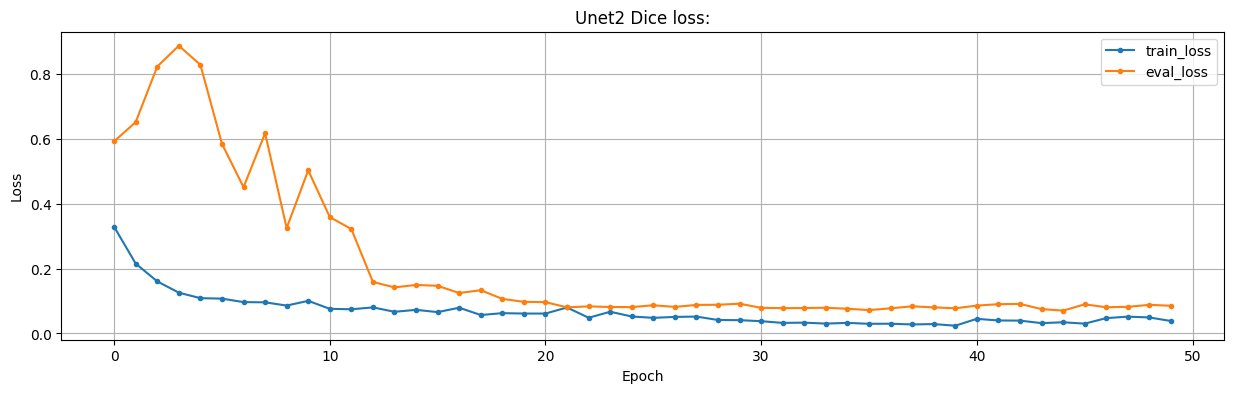

In [75]:
plt.title("Unet2 Dice loss:")
total_train = torch.tensor(total_train)
total_val = torch.tensor(total_val)
plt.plot(total_train, label="train_loss", marker=".")
plt.plot(total_val, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [79]:
epochs = 50
unet_bce = UNet().to(device)
optimizer = optim.Adam(unet_bce.parameters(), lr=0.0001)
model, statistics = train(unet_bce, optimizer, bce_loss , epochs, train_dataloader, valid_dataloader, device)
total_train = statistics['train loss']
total_val = statistics['val_loss']

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.7329006195068359
Epoch 0: val loss = 0.6933358907699585
Epoch 0: val iou = 0.0006308302981778979


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.6388183832168579
Epoch 1: val loss = 0.6931949853897095
Epoch 1: val iou = 0.00022395397536456585


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.6194683909416199
Epoch 2: val loss = 0.693148136138916
Epoch 2: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.6029322147369385
Epoch 3: val loss = 0.6931473016738892
Epoch 3: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.5967100858688354
Epoch 4: val loss = 0.6931471228599548
Epoch 4: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.5973743200302124
Epoch 5: val loss = 0.6931471228599548
Epoch 5: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.5985202789306641
Epoch 6: val loss = 0.6812984943389893
Epoch 6: val iou = 0.11920976638793945


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.5973491072654724
Epoch 7: val loss = 0.6789717078208923
Epoch 7: val iou = 0.18147355318069458


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.5967862606048584
Epoch 8: val loss = 0.671786904335022
Epoch 8: val iou = 0.23679575324058533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.58856201171875
Epoch 9: val loss = 0.6523895263671875
Epoch 9: val iou = 0.4872076213359833


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.5933789014816284
Epoch 10: val loss = 0.6628116369247437
Epoch 10: val iou = 0.4557655453681946


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.5935397744178772
Epoch 11: val loss = 0.6423364877700806
Epoch 11: val iou = 0.5332909822463989


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.5904573798179626
Epoch 12: val loss = 0.6184480786323547
Epoch 12: val iou = 0.7127046585083008


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.5878793001174927
Epoch 13: val loss = 0.641600489616394
Epoch 13: val iou = 0.6321466565132141


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.5878862142562866
Epoch 14: val loss = 0.6333096027374268
Epoch 14: val iou = 0.6935763359069824


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.5908795595169067
Epoch 15: val loss = 0.62401282787323
Epoch 15: val iou = 0.63276207447052


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.5869976878166199
Epoch 16: val loss = 0.610146164894104
Epoch 16: val iou = 0.7913422584533691


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.5876597166061401
Epoch 17: val loss = 0.6104547381401062
Epoch 17: val iou = 0.7995224595069885


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.5829890966415405
Epoch 18: val loss = 0.6120465993881226
Epoch 18: val iou = 0.7917296886444092


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.5836963653564453
Epoch 19: val loss = 0.6104351282119751
Epoch 19: val iou = 0.8020049333572388


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: train loss = 0.5799693465232849
Epoch 20: val loss = 0.60440993309021
Epoch 20: val iou = 0.8299993276596069


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21: train loss = 0.5797567367553711
Epoch 21: val loss = 0.6040127277374268
Epoch 21: val iou = 0.8371084928512573


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22: train loss = 0.580132246017456
Epoch 22: val loss = 0.605902373790741
Epoch 22: val iou = 0.819138765335083


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23: train loss = 0.58135986328125
Epoch 23: val loss = 0.6025301814079285
Epoch 23: val iou = 0.8367614150047302


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24: train loss = 0.5795326232910156
Epoch 24: val loss = 0.6043241024017334
Epoch 24: val iou = 0.8341779112815857


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25: train loss = 0.5791489481925964
Epoch 25: val loss = 0.6040542125701904
Epoch 25: val iou = 0.8400437831878662


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26: train loss = 0.5816759467124939
Epoch 26: val loss = 0.6027865409851074
Epoch 26: val iou = 0.8497859239578247


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27: train loss = 0.5790525078773499
Epoch 27: val loss = 0.6022689342498779
Epoch 27: val iou = 0.841942548751831


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28: train loss = 0.5769741535186768
Epoch 28: val loss = 0.6003438234329224
Epoch 28: val iou = 0.8617095351219177


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29: train loss = 0.5778201818466187
Epoch 29: val loss = 0.5997321605682373
Epoch 29: val iou = 0.8586015701293945


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30: train loss = 0.576570451259613
Epoch 30: val loss = 0.6056061387062073
Epoch 30: val iou = 0.82619708776474


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31: train loss = 0.5763489007949829
Epoch 31: val loss = 0.6075693368911743
Epoch 31: val iou = 0.8193324208259583


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32: train loss = 0.5775300860404968
Epoch 32: val loss = 0.6052312850952148
Epoch 32: val iou = 0.8368252515792847


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33: train loss = 0.5817937254905701
Epoch 33: val loss = 0.6025389432907104
Epoch 33: val iou = 0.8581447601318359


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34: train loss = 0.5796069502830505
Epoch 34: val loss = 0.6074029207229614
Epoch 34: val iou = 0.8284169435501099


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35: train loss = 0.5804879665374756
Epoch 35: val loss = 0.6024736762046814
Epoch 35: val iou = 0.8311846852302551


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36: train loss = 0.5803611278533936
Epoch 36: val loss = 0.6084490418434143
Epoch 36: val iou = 0.8243162631988525


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37: train loss = 0.5794165730476379
Epoch 37: val loss = 0.6039607524871826
Epoch 37: val iou = 0.8384941816329956


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38: train loss = 0.5801392793655396
Epoch 38: val loss = 0.6080974340438843
Epoch 38: val iou = 0.8130755424499512


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39: train loss = 0.5835175514221191
Epoch 39: val loss = 0.6020759344100952
Epoch 39: val iou = 0.8487298488616943


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40: train loss = 0.5780397653579712
Epoch 40: val loss = 0.6027368307113647
Epoch 40: val iou = 0.8470611572265625


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41: train loss = 0.5757483839988708
Epoch 41: val loss = 0.6068345308303833
Epoch 41: val iou = 0.8269641399383545


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42: train loss = 0.575990617275238
Epoch 42: val loss = 0.6042516231536865
Epoch 42: val iou = 0.8429518342018127


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43: train loss = 0.5762063264846802
Epoch 43: val loss = 0.6072692275047302
Epoch 43: val iou = 0.8238036632537842


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44: train loss = 0.5751956105232239
Epoch 44: val loss = 0.6033079624176025
Epoch 44: val iou = 0.8560730218887329


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45: train loss = 0.5791934728622437
Epoch 45: val loss = 0.6004245281219482
Epoch 45: val iou = 0.854191780090332


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46: train loss = 0.5771055817604065
Epoch 46: val loss = 0.6054636836051941
Epoch 46: val iou = 0.8350470066070557


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47: train loss = 0.5739558935165405
Epoch 47: val loss = 0.601655125617981
Epoch 47: val iou = 0.8294017314910889


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48: train loss = 0.5739631652832031
Epoch 48: val loss = 0.6019002199172974
Epoch 48: val iou = 0.8506277799606323


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49: train loss = 0.5750093460083008
Epoch 49: val loss = 0.5993317365646362
Epoch 49: val iou = 0.8602461814880371


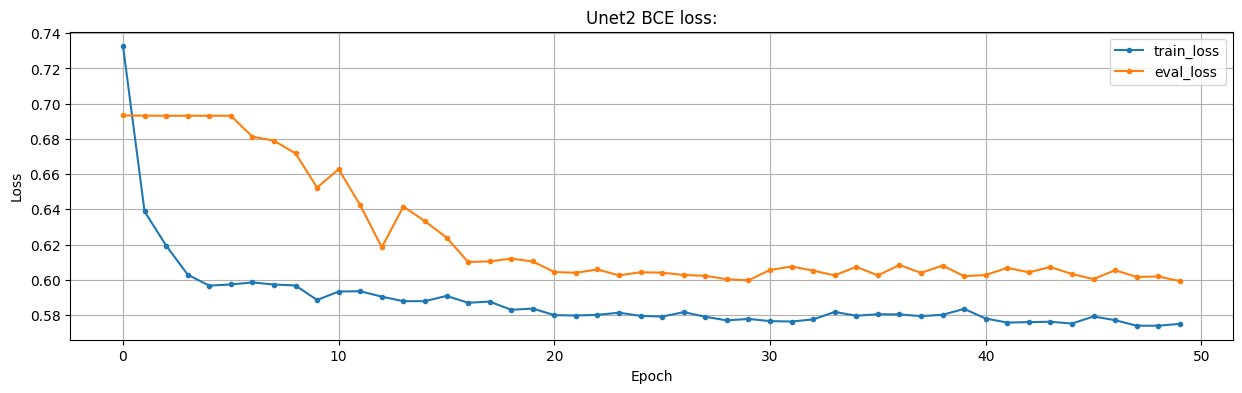

In [80]:
plt.title("Unet2 BCE loss:")
total_train = torch.tensor(total_train)
total_val = torch.tensor(total_val)
plt.plot(total_train, label="train_loss", marker=".")
plt.plot(total_val, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [81]:
epochs = 50
unet_bce = UNet().to(device)
optimizer = optim.Adam(unet_bce.parameters(), lr=0.0001)
model, statistics = train(unet_bce, optimizer, focal_loss , epochs, train_dataloader, valid_dataloader, device)
total_train = statistics['train loss']
total_val = statistics['val_loss']

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.19208739697933197
Epoch 0: val loss = 0.1732867807149887
Epoch 0: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.147056445479393
Epoch 1: val loss = 0.1732867807149887
Epoch 1: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.14213618636131287
Epoch 2: val loss = 0.1732867807149887
Epoch 2: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.14163675904273987
Epoch 3: val loss = 0.1732867807149887
Epoch 3: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.14126281440258026
Epoch 4: val loss = 0.1732867807149887
Epoch 4: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.14023414254188538
Epoch 5: val loss = 0.1694471538066864
Epoch 5: val iou = 0.10479135811328888


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.14071519672870636
Epoch 6: val loss = 0.17088353633880615
Epoch 6: val iou = 0.055545032024383545


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.14010347425937653
Epoch 7: val loss = 0.16997841000556946
Epoch 7: val iou = 0.07653191685676575


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.13994896411895752
Epoch 8: val loss = 0.16195224225521088
Epoch 8: val iou = 0.34828075766563416


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.13781890273094177
Epoch 9: val loss = 0.1562052071094513
Epoch 9: val iou = 0.46628865599632263


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.1398213654756546
Epoch 10: val loss = 0.15196213126182556
Epoch 10: val iou = 0.5236023664474487


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.1367352157831192
Epoch 11: val loss = 0.15136945247650146
Epoch 11: val iou = 0.6153086423873901


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.13622187077999115
Epoch 12: val loss = 0.15475758910179138
Epoch 12: val iou = 0.62649005651474


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.13686515390872955
Epoch 13: val loss = 0.15094369649887085
Epoch 13: val iou = 0.6572412252426147


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.13485056161880493
Epoch 14: val loss = 0.15128973126411438
Epoch 14: val iou = 0.6579470634460449


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.13774430751800537
Epoch 15: val loss = 0.15514922142028809
Epoch 15: val iou = 0.6910226345062256


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.13485988974571228
Epoch 16: val loss = 0.14605331420898438
Epoch 16: val iou = 0.7253972291946411


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.13541965186595917
Epoch 17: val loss = 0.14585833251476288
Epoch 17: val iou = 0.7473218441009521


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.13473907113075256
Epoch 18: val loss = 0.145639568567276
Epoch 18: val iou = 0.7487473487854004


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.13399165868759155
Epoch 19: val loss = 0.14350377023220062
Epoch 19: val iou = 0.7714633941650391


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: train loss = 0.13366767764091492
Epoch 20: val loss = 0.14381089806556702
Epoch 20: val iou = 0.7890320420265198


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21: train loss = 0.13274723291397095
Epoch 21: val loss = 0.1423255205154419
Epoch 21: val iou = 0.8100658655166626


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22: train loss = 0.13218224048614502
Epoch 22: val loss = 0.1433926522731781
Epoch 22: val iou = 0.7898545265197754


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23: train loss = 0.1329917460680008
Epoch 23: val loss = 0.1397200971841812
Epoch 23: val iou = 0.8303132653236389


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24: train loss = 0.13205692172050476
Epoch 24: val loss = 0.14172345399856567
Epoch 24: val iou = 0.8201922178268433


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25: train loss = 0.1352287232875824
Epoch 25: val loss = 0.14247021079063416
Epoch 25: val iou = 0.7855558395385742


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26: train loss = 0.13301438093185425
Epoch 26: val loss = 0.14378401637077332
Epoch 26: val iou = 0.8118287324905396


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27: train loss = 0.13346624374389648
Epoch 27: val loss = 0.14203689992427826
Epoch 27: val iou = 0.8178365230560303


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28: train loss = 0.13240297138690948
Epoch 28: val loss = 0.14125871658325195
Epoch 28: val iou = 0.8271859884262085


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29: train loss = 0.13107091188430786
Epoch 29: val loss = 0.1412818282842636
Epoch 29: val iou = 0.8295971155166626


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30: train loss = 0.13076752424240112
Epoch 30: val loss = 0.1418166160583496
Epoch 30: val iou = 0.8289893865585327


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31: train loss = 0.13022595643997192
Epoch 31: val loss = 0.1422586739063263
Epoch 31: val iou = 0.7979987859725952


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32: train loss = 0.12997783720493317
Epoch 32: val loss = 0.14222592115402222
Epoch 32: val iou = 0.8307498693466187


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33: train loss = 0.13073638081550598
Epoch 33: val loss = 0.1408884972333908
Epoch 33: val iou = 0.8338214159011841


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34: train loss = 0.12945330142974854
Epoch 34: val loss = 0.14003367722034454
Epoch 34: val iou = 0.8263764381408691


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35: train loss = 0.13001467287540436
Epoch 35: val loss = 0.14127686619758606
Epoch 35: val iou = 0.8297507762908936


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36: train loss = 0.12916457653045654
Epoch 36: val loss = 0.1428062617778778
Epoch 36: val iou = 0.8256604075431824


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37: train loss = 0.1310776025056839
Epoch 37: val loss = 0.1393870711326599
Epoch 37: val iou = 0.83814537525177


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38: train loss = 0.13005898892879486
Epoch 38: val loss = 0.14245480298995972
Epoch 38: val iou = 0.8222522735595703


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39: train loss = 0.1317805051803589
Epoch 39: val loss = 0.14230117201805115
Epoch 39: val iou = 0.8256827592849731


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40: train loss = 0.12983031570911407
Epoch 40: val loss = 0.14431080222129822
Epoch 40: val iou = 0.8357694149017334


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41: train loss = 0.13263186812400818
Epoch 41: val loss = 0.139213427901268
Epoch 41: val iou = 0.8483958840370178


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42: train loss = 0.1313943713903427
Epoch 42: val loss = 0.13999584317207336
Epoch 42: val iou = 0.8294660449028015


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43: train loss = 0.1301524043083191
Epoch 43: val loss = 0.14111390709877014
Epoch 43: val iou = 0.8483044505119324


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44: train loss = 0.1302207112312317
Epoch 44: val loss = 0.14087258279323578
Epoch 44: val iou = 0.8308061361312866


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45: train loss = 0.12895898520946503
Epoch 45: val loss = 0.1424938291311264
Epoch 45: val iou = 0.8208239078521729


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46: train loss = 0.12955237925052643
Epoch 46: val loss = 0.14054065942764282
Epoch 46: val iou = 0.8396885395050049


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47: train loss = 0.1299521028995514
Epoch 47: val loss = 0.14127010107040405
Epoch 47: val iou = 0.8423348665237427


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48: train loss = 0.13034459948539734
Epoch 48: val loss = 0.14219552278518677
Epoch 48: val iou = 0.8303563594818115


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49: train loss = 0.1294323205947876
Epoch 49: val loss = 0.14239013195037842
Epoch 49: val iou = 0.826927900314331


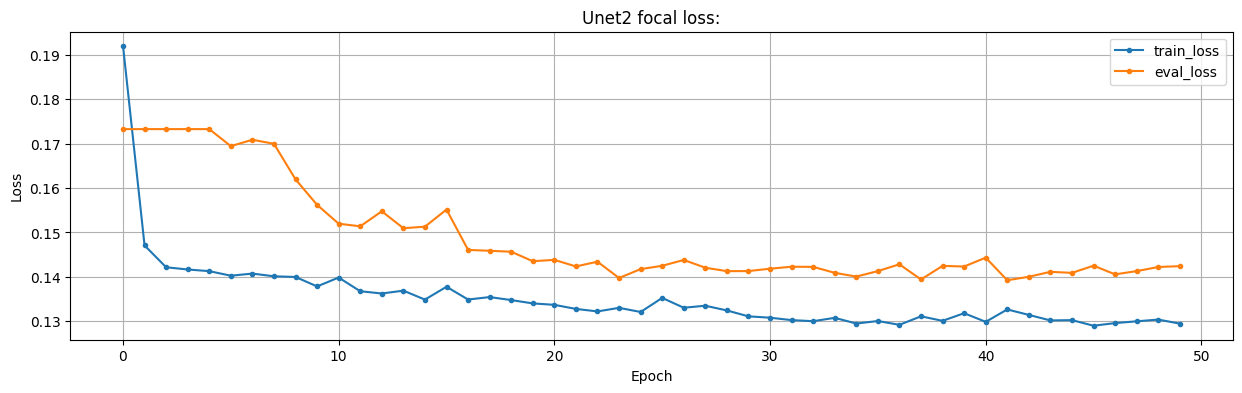

In [82]:
plt.title("Unet2 focal loss:")
total_train = torch.tensor(total_train)
total_val = torch.tensor(total_val)
plt.plot(total_train, label="train_loss", marker=".")
plt.plot(total_val, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [83]:
import tensorflow as tf
import keras.backend as K

In [85]:
 def ssim_loss(y_real, y_pred):
        """
        Structural Similarity Index (SSIM) loss
        """
        return 1 - tf.image.ssim(y_real, y_pred, max_val=1)